In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
pd.set_option('display.max_rows', 42)
pd.set_option('display.max_columns', 42)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sinau/DAC ITS/PRELIMINARY ROUND/DataTrain_Preliminary.csv', sep=';')
test = pd.read_csv('/content/drive/MyDrive/Sinau/DAC ITS/PRELIMINARY ROUND/Data_Prediction.csv', sep=';')
df.head()

FileNotFoundError: ignored

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112446 entries, 0 to 112445
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     112446 non-null  object 
 1   protocol_type                111778 non-null  object 
 2   service                      111426 non-null  object 
 3   flag                         111593 non-null  object 
 4   src_bytes                    112446 non-null  object 
 5   dst_bytes                    112446 non-null  object 
 6   land                         112446 non-null  object 
 7   wrong_fragment               112446 non-null  object 
 8   urgent                       112446 non-null  object 
 9   hot                          112446 non-null  object 
 10  num_failed_logins            112446 non-null  object 
 11  logged_in                    112446 non-null  object 
 12  num_compromised              112446 non-null  object 
 13 

In [ ]:
df.type_of_attack.value_counts(normalize=False)

normal                      60538
neptune                     37142
ipsweep                      3254
satan                        3248
portsweep                    2687
smurf                        2394
Denial of Service Attack     1861
nmap                         1322
Name: type_of_attack, dtype: int64

In [ ]:
df.select_dtypes(include='float64').columns

Index(['dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_serror_rate'],
      dtype='object')

In [ ]:
df.isna().sum().sort_values(ascending=False)

service                        1020
flag                            853
protocol_type                   668
dst_host_same_src_port_rate     438
dst_host_serror_rate            428
dst_host_same_srv_rate          328
dst_host_diff_srv_rate          243
dst_host_srv_serror_rate          0
dst_host_rerror_rate              0
dst_host_srv_diff_host_rate       0
dst_host_srv_rerror_rate          0
srv_count                         0
dst_host_srv_count                0
dst_host_count                    0
srv_diff_host_rate                0
diff_srv_rate                     0
same_srv_rate                     0
srv_rerror_rate                   0
rerror_rate                       0
srv_serror_rate                   0
serror_rate                       0
duration                          0
is_guest_login                    0
count                             0
logged_in                         0
src_bytes                         0
dst_bytes                         0
land                        

Missing values handling

In [ ]:
# types convertion
def convert_data():
    for kolom in df.columns:
        if kolom in df.columns[[0, 4,5,7,8,9,10,12,15,16,17,18,19,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]].values:
            df[kolom] = pd.to_numeric(df[kolom], errors='coerce', downcast='float')
        elif kolom in df.columns[[6,11,13,14,20,21]].values:
            df[kolom] = pd.to_numeric(df[kolom], errors='coerce', downcast='signed')
    return df

convert_data()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0.0,tcp,private,SH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,176.0,1.0,0.01,0.94,0.95,0.0,0.95,1.0,0.0,0.0,nmap
1,0.0,tcp,private,S0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,5.0,1.0,1.0,0.0,0.0,NaN,NaN,0.0,255.0,5.0,0.02,0.08,0.00,0.0,1.00,1.0,0.0,0.0,neptune
2,0.0,tcp,http,SF,285.0,3623.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,15.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,115.0,228.0,1.00,0.00,0.01,NaN,0.00,0.0,0.0,0.0,normal
3,0.0,tcp,http,SF,232.0,584.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,255.0,1.00,0.00,0.17,NaN,0.00,0.0,0.0,0.0,normal
4,1.0,tcp,smtp,SF,1080.0,327.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,202.0,154.0,0.58,0.02,0.00,NaN,0.00,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112441,0.0,tcp,http,REJ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,7.0,255.0,1.00,0.00,0.14,NaN,0.00,0.0,NaN,NaN,normal
112442,0.0,tcp,http,SF,309.0,758.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,48.0,255.0,1.00,0.00,0.02,NaN,0.02,NaN,0.0,0.0,normal
112443,0.0,tcp,http,SF,363.0,721.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.0,35.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,255.0,255.0,1.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,normal
112444,0.0,tcp,discard,RSTO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,213.0,7.0,0.0,0.0,1.0,1.0,NaN,NaN,0.0,255.0,7.0,0.03,0.06,0.00,0.0,0.00,0.0,1.0,1.0,neptune


In [ ]:
df.protocol_type.value_counts()

tcp     90997
udp     13364
icmp     7417
Name: protocol_type, dtype: int64

In [ ]:
df.isna().sum().sort_values(ascending=False)

same_srv_rate                  42151
diff_srv_rate                  41890
dst_host_srv_diff_host_rate    33958
srv_diff_host_rate             18379
dst_host_rerror_rate           11350
dst_host_srv_rerror_rate        5867
dst_host_srv_serror_rate        5852
serror_rate                     4614
rerror_rate                     3398
srv_serror_rate                 2515
srv_rerror_rate                 1812
service                         1020
hot                              918
flag                             853
src_bytes                        851
dst_bytes                        706
protocol_type                    668
num_access_files                 591
dst_host_count                   588
dst_host_srv_count               563
duration                         557
wrong_fragment                   523
dst_host_same_src_port_rate      438
dst_host_serror_rate             428
num_failed_logins                405
num_compromised                  352
dst_host_same_srv_rate           328
i

In [ ]:
df.groupby(['protocol_type']).mean()

<ipython-input-17-2daa3cc0759c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['protocol_type']).mean()


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
protocol_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
icmp,161.963562,2546.161158,13.815833,13.542660,0.023221,13.489680,0.000000,40.573032,0.000000,53.936893,54.317762,13.484223,0.000000,0.000000,68.277344,0.000000,0.0,0.000000,13.540826,133.880585,158.831039,0.000000,53.987854,701.368774,0.000000,785.588013,86.021065,0.431569,231.989288,562.151489,82.420708,13.587098,0.792708,2497.436279,54.074360,0.000000,0.000000,0.000000
tcp,597.618958,45760.543480,26168.298760,104.590201,0.000000,61.706779,0.170823,166.546448,0.479536,84.166588,140.779921,62.771218,0.359022,0.014902,156.343445,28.750147,0.0,0.000011,92.527762,1014.801880,701.647339,119.266258,372.858887,400.362732,16.941000,351.571411,575.567322,0.048695,424.223572,174.293381,510.275818,265.374298,66.268509,647.127625,161.450623,0.360972,76.066719,0.138705
udp,1037.787109,93.181122,108.741957,218.042932,0.174820,82.618973,0.000000,187.432526,0.000000,142.256744,239.877661,157.184057,0.000000,0.000000,254.831802,52.540195,0.0,0.000000,180.680268,141.556396,192.537323,0.000000,203.433777,888.746094,37.718391,401.577637,405.237976,0.042649,557.288818,154.543991,802.814087,187.779617,0.273311,838.566223,97.564232,0.000000,125.270172,0.000000


handling missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33279 entries, 0 to 33278
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     33117 non-null  float32
 1   protocol_type                33080 non-null  object 
 2   service                      32986 non-null  object 
 3   flag                         33010 non-null  object 
 4   src_bytes                    33023 non-null  float32
 5   dst_bytes                    33063 non-null  float32
 6   land                         33194 non-null  float64
 7   wrong_fragment               33126 non-null  float32
 8   urgent                       33217 non-null  float32
 9   hot                          32996 non-null  float32
 10  num_failed_logins            33154 non-null  float32
 11  logged_in                    33232 non-null  float64
 12  num_compromised              33189 non-null  float32
 13  root_shell      

In [ ]:
df.groupby('type_of_attack').mean()

<ipython-input-18-363fe90a083b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('type_of_attack').mean()


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
type_of_attack,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Denial of Service Attack,0.098940,24517.214844,3691.252686,0.003597,1.415913,0.000000,0.859779,0.000000,0.452297,0.415194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,27.708334,23.309187,0.005758,1601.412842,2642.250000,0.000000,1.000000,0.000000,0.019190,3176.355225,97.138054,0.629046,0.116731,0.184399,0.003774,0.022049,0.001883,0.000000,0.000000
ipsweep,13.164103,1373.646118,54.052307,0.000000,0.000000,0.000000,0.000000,0.000000,0.010256,0.004103,0.000000,0.000000,0.004103,0.018462,0.000000,0.000000,0.0,0.000000,0.000000,1.005128,18.653725,0.000000,0.000000,0.126154,0.126154,1337.046265,0.002088,0.698462,6.628245,1242.581421,0.864810,0.143628,0.864790,8889.458008,0.000000,0.000000,0.023838,0.119917
neptune,0.000184,0.990753,0.081218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2371.293457,1652.138062,271.123322,849.213867,0.166138,0.164978,2894.994629,21333.179688,0.000185,340.390228,170.167252,284.697083,210.957138,210.892471,0.000093,129.626373,0.832991,0.165527,0.164902
nmap,0.000000,38.529869,0.247525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.190594,18.254950,0.131188,0.131188,4455.400879,0.000000,1.000000,0.002481,0.673267,41.750000,99.311882,0.818762,0.127946,0.936089,5925.866699,0.120421,0.131188,0.000000,0.000000
normal,783.174622,12866.408203,4065.518555,222.615817,0.000000,105.913651,0.242314,222.666443,0.707234,134.291473,266.932655,122.331739,0.853792,0.019607,306.455627,39.040985,0.0,0.000056,139.442443,123.610550,123.478409,0.005623,28.850979,577.163818,39.735241,256.627441,353.556488,0.095385,247.677490,189.822113,759.345154,278.775452,0.124065,1599.987305,161.896194,0.000485,175.268234,0.021916
portsweep,8083.848145,0.338603,0.000000,0.000000,0.000000,0.000000,0.003793,2199.201904,0.001264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,34.850822,1.424779,0.004021,0.026110,0.986111,0.964752,0.936027,0.156398,0.000000,3391.973389,2.008850,0.007889,0.539241,0.711745,0.000000,0.020784,0.024804,0.997059,0.964380
satan,0.117895,6.332632,23.200434,0.000000,0.000000,0.000000,0.005263,736.834717,0.014737,0.002105,0.000000,0.000000,0.002105,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,227.378952,7.374737,0.000000,0.031612,5089.020508,0.559536,0.136364,0.888710,0.002107,248.898941,14.040000,0.056232,0.668021,0.247432,0.000000,0.062463,0.031612,0.025000,0.559536
smurf,0.000000,5840.172852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,378.317535,378.311768,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,235.520111,160.173843,0.684540,0.032557,0.682830,0.000000,0.014325,0.000000,0.000000,0.000000


In [ ]:
df.type_of_attack.value_counts(normalize=True)

normal                      0.540597
neptune                     0.327724
ipsweep                     0.029299
satan                       0.028547
portsweep                   0.023769
smurf                       0.020915
Denial of Service Attack    0.017008
nmap                        0.012140
Name: type_of_attack, dtype: float64

In [ ]:
# missing value handlings
for i in df.type_of_attack.unique():
  df[df.type_of_attack == i] = df[df.type_of_attack == i].fillna(df[df.type_of_attack == i].mean())
df.isna().sum()

<ipython-input-21-8864a1bbffc4>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[df.type_of_attack == i] = df[df.type_of_attack == i].fillna(df[df.type_of_attack == i].mean())
<ipython-input-21-8864a1bbffc4>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[df.type_of_attack == i] = df[df.type_of_attack == i].fillna(df[df.type_of_attack == i].mean())
<ipython-input-21-8864a1bbffc4>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, s

duration                          0
protocol_type                   668
service                        1020
flag                            853
src_bytes                         0
dst_bytes                         0
land                              0
wrong_fragment                    0
urgent                            0
hot                               0
num_failed_logins                 0
logged_in                         0
num_compromised                   0
root_shell                        0
su_attempted                      0
num_root                          0
num_file_creations                0
num_shells                        0
num_access_files                  0
num_outbound_cmds                 0
is_host_login                     0
is_guest_login                    0
count                             0
srv_count                         0
serror_rate                       0
srv_serror_rate                   0
rerror_rate                       0
srv_rerror_rate             

In [ ]:
df = df.fillna(df.median())

<ipython-input-27-a187aa03e3ee>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.median())


In [ ]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0.0,tcp,private,SH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.000000,0.000000,0.00000,176.0,1.0,0.01,0.94,0.95,0.000000,0.95,1.0,0.0,0.0,nmap
1,0.0,tcp,private,S0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,5.0,1.0,1.0,0.0,0.0,3004.885254,21296.169922,0.00000,255.0,5.0,0.02,0.08,0.00,0.000000,1.00,1.0,0.0,0.0,neptune
2,0.0,tcp,http,SF,285.0,3623.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,15.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.09687,115.0,228.0,1.00,0.00,0.01,1622.579468,0.00,0.0,0.0,0.0,normal
3,0.0,tcp,http,SF,232.0,584.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.00000,6.0,255.0,1.00,0.00,0.17,1622.579468,0.00,0.0,0.0,0.0,normal
4,1.0,tcp,smtp,SF,1080.0,327.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.000000,0.000000,1.00000,202.0,154.0,0.58,0.02,0.00,1622.579468,0.00,0.0,0.0,0.0,normal


In [ ]:
# drop missing values
df.dropna(inplace=True)

In [ ]:
df.shape

(110004, 42)

EDA

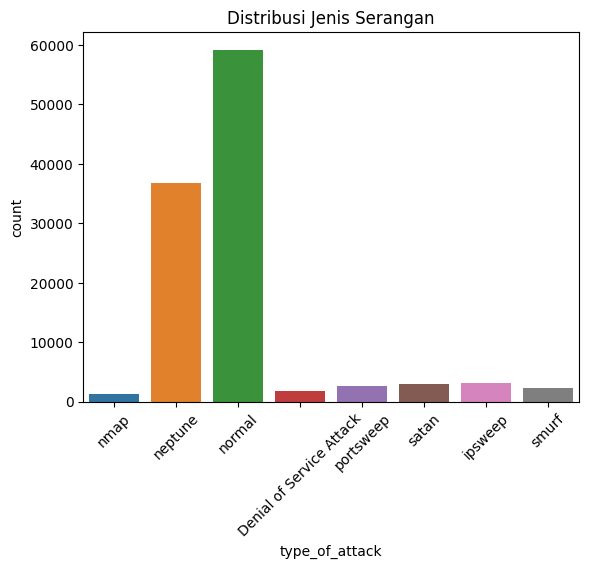

In [ ]:
sns.countplot(x="type_of_attack", data=df)
plt.title("Distribusi Jenis Serangan")
plt.xticks(rotation=45)
plt.show()

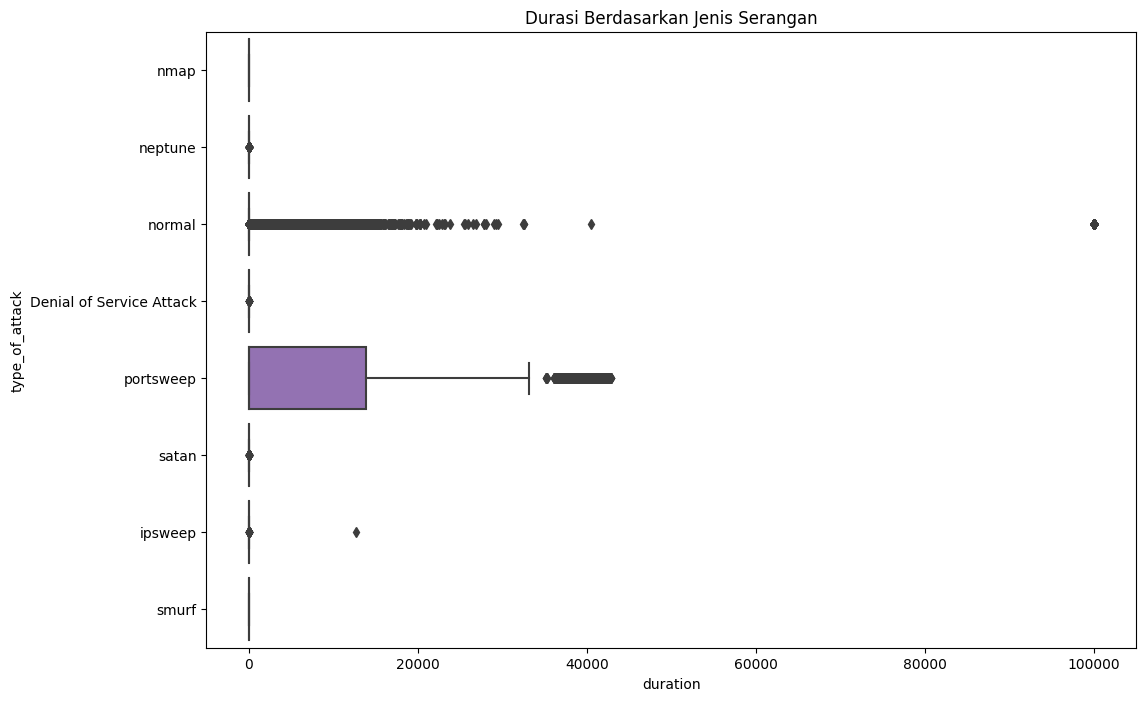

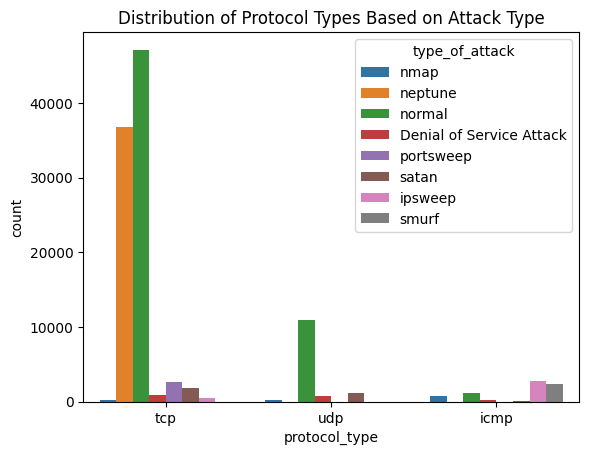

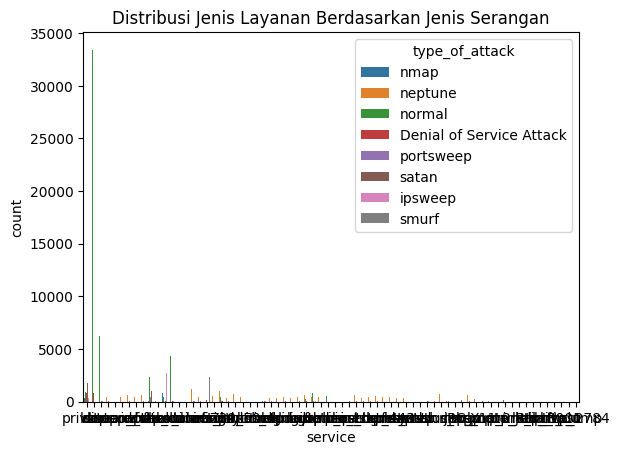

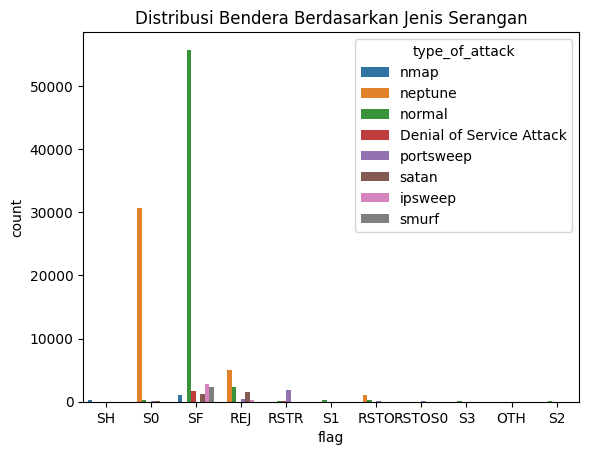

In [ ]:
 plt.figure(figsize=(12, 8))
sns.boxplot(x="duration", y="type_of_attack", data=df)
plt.title("Durasi Berdasarkan Jenis Serangan")
plt.show()

sns.countplot(x="protocol_type", hue="type_of_attack", data=df)
plt.title("Distribution of Protocol Types Based on Attack Type")
plt.show()

sns.countplot(x="service", hue="type_of_attack", data=df)
plt.title("Distribusi Jenis Layanan Berdasarkan Jenis Serangan")
plt.show()

sns.countplot(x="flag", hue="type_of_attack", data=df)
plt.title("Distribusi Bendera Berdasarkan Jenis Serangan")
plt.show()

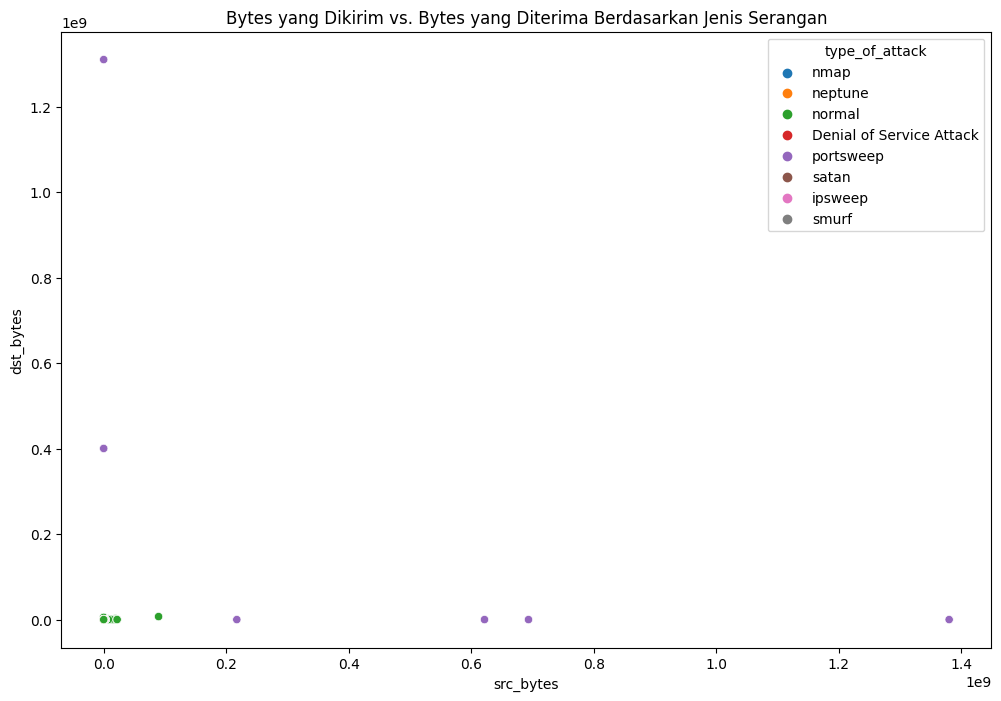

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x="src_bytes", y="dst_bytes", hue="type_of_attack", data=df)
plt.title("Bytes yang Dikirim vs. Bytes yang Diterima Berdasarkan Jenis Serangan")
plt.show()


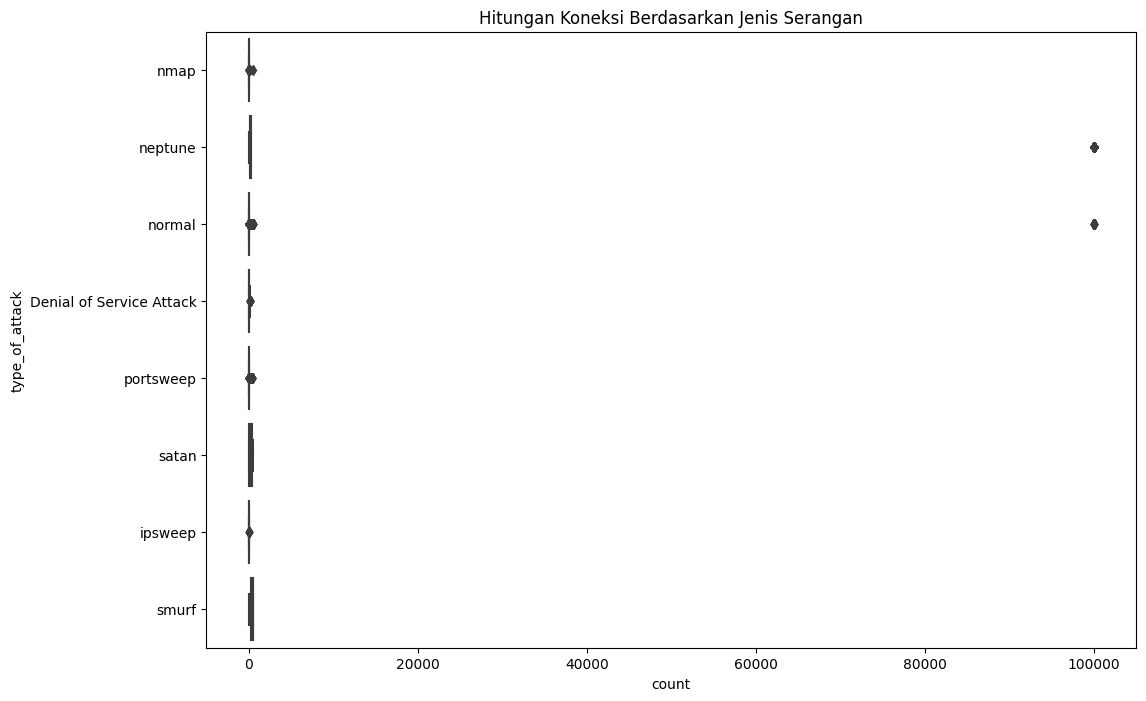

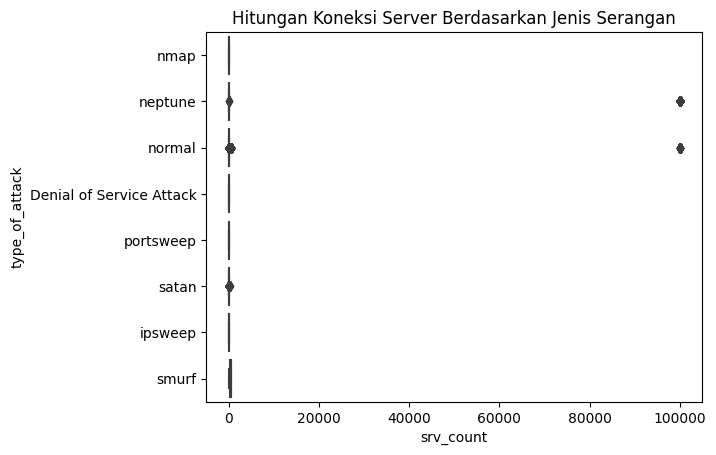

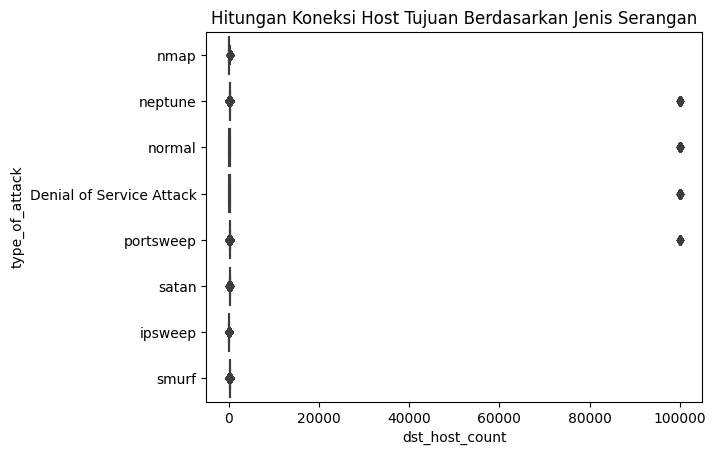

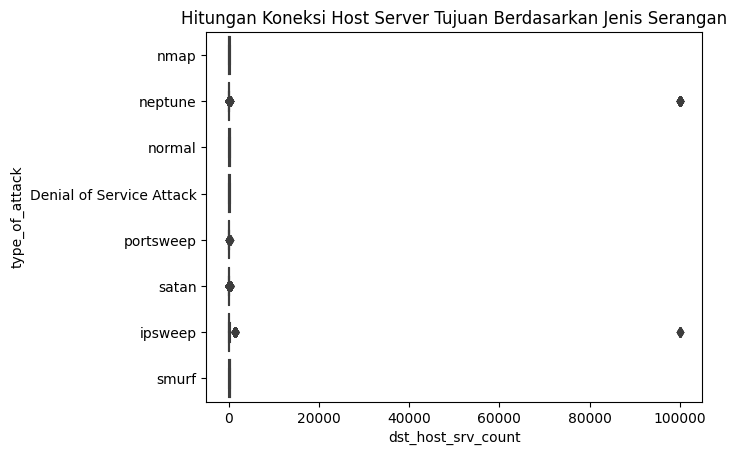

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="count", y="type_of_attack", data=df)
plt.title("Hitungan Koneksi Berdasarkan Jenis Serangan")
plt.show()

sns.boxplot(x="srv_count", y="type_of_attack", data=df)
plt.title("Hitungan Koneksi Server Berdasarkan Jenis Serangan")
plt.show()

sns.boxplot(x="dst_host_count", y="type_of_attack", data=df)
plt.title("Hitungan Koneksi Host Tujuan Berdasarkan Jenis Serangan")
plt.show()

sns.boxplot(x="dst_host_srv_count", y="type_of_attack", data=df)
plt.title("Hitungan Koneksi Host Server Tujuan Berdasarkan Jenis Serangan")
plt.show()

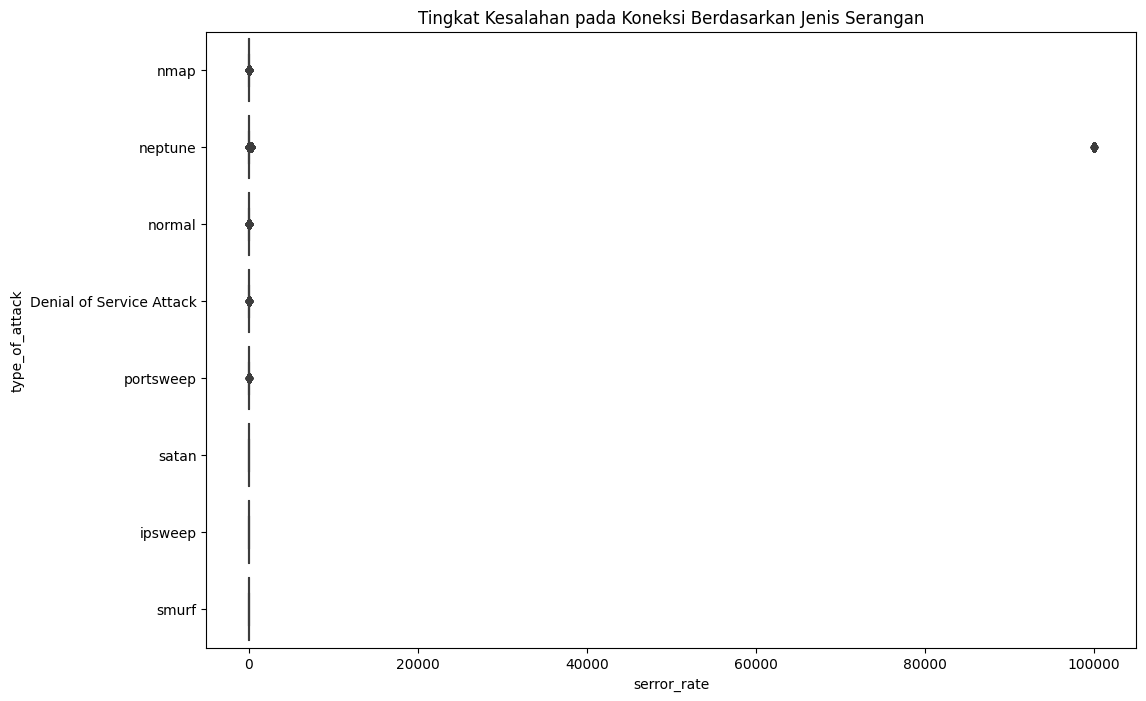

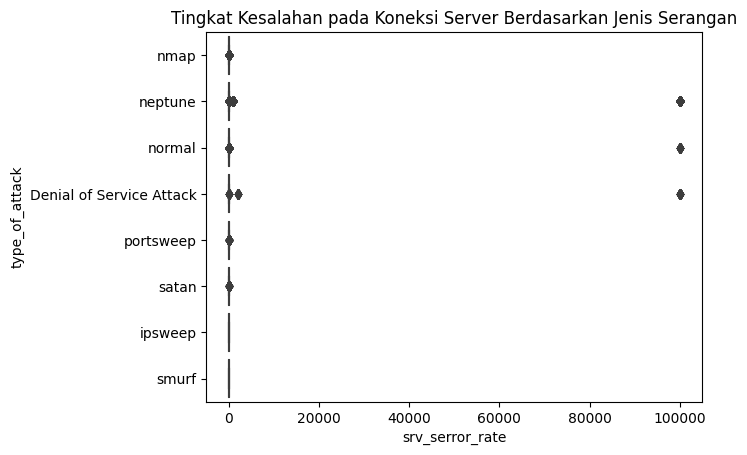

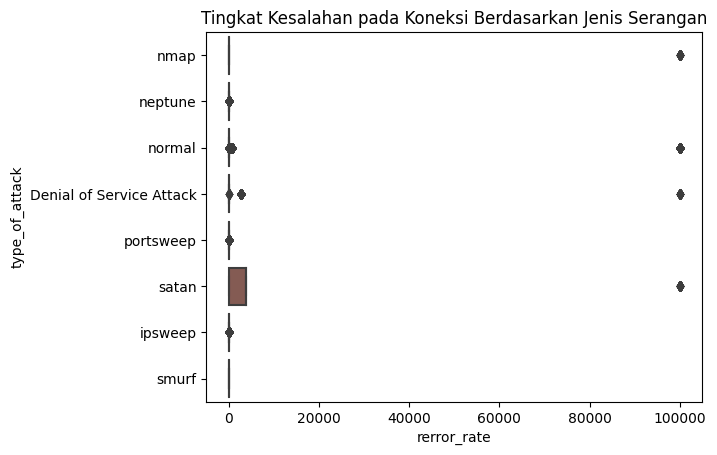

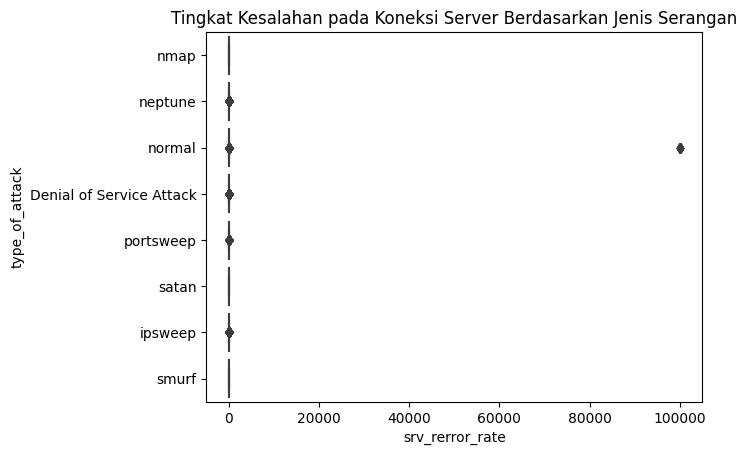

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="serror_rate", y="type_of_attack", data=df)
plt.title("Tingkat Kesalahan pada Koneksi Berdasarkan Jenis Serangan")
plt.show()

sns.boxplot(x="srv_serror_rate", y="type_of_attack", data=df)
plt.title("Tingkat Kesalahan pada Koneksi Server Berdasarkan Jenis Serangan")
plt.show()

sns.boxplot(x="rerror_rate", y="type_of_attack", data=df)
plt.title("Tingkat Kesalahan pada Koneksi Berdasarkan Jenis Serangan")
plt.show()

sns.boxplot(x="srv_rerror_rate", y="type_of_attack", data=df)
plt.title("Tingkat Kesalahan pada Koneksi Server Berdasarkan Jenis Serangan")
plt.show()

In [ ]:
X = df.drop('type_of_attack', axis=1)
y = df.type_of_attack

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((88003, 41), (22001, 41), (88003,), (22001,))

In [ ]:
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(include='object').columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat',cat_pipeline, cat_cols)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', lgb.LGBMClassifier(random_state=42))
])

grid_params = {
 'algo__learning_rate': [0.01,0.1],
 'algo__n_estimators': [100,150,200],
 'algo__num_leaves': [30,31],
 'algo__reg_alpha': [0.0, 0.1],
 'algo__reg_lambda': [0.0, 0.1],
}

model = GridSearchCV(pipeline, grid_params, cv=3, n_jobs=-1, scoring='f1_macro')

model.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2521
[LightGBM] [Info] Number of data points in the train set: 88003, number of used features: 112
[LightGBM] [Info] Start training from score -4.117601
[LightGBM] [Info] Start training from score -3.561080
[LightGBM] [Info] Start training from score -1.090644
[LightGBM] [Info] Start training from score -4.509894
[LightGBM] [Info] Start training from score -0.621241
[LightGBM] [Info] Start training from score -3.762462
[LightGBM] [Info] Start training from score -3.626366
[LightGBM] [Info] Start training from score -3.854110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'nu...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['protocol_type', 'service', 'flag'], dtype='object'))])),
                                       ('algo',
                                        LGBMClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'algo__learning_rate': [0.01, 0.1],
                         'algo__n_estimators': [100, 150, 200],
                         'algo__num_leaves': [30, 31],
                         'algo__reg_alpha': [0.0, 0.1],
                         'algo__reg_lambda': [0.0, 0.1]},
             scoring='f1_macro')

In [ ]:
pipeline['algo'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

Denial of Service Attack       1.00      1.00      1.00       342
                 ipsweep       1.00      1.00      1.00       620
                 neptune       1.00      1.00      1.00      7246
                    nmap       1.00      1.00      1.00       244
                  normal       1.00      1.00      1.00     11938
               portsweep       1.00      1.00      1.00       517
                   satan       1.00      1.00      1.00       622
                   smurf       1.00      1.00      1.00       472

                accuracy                           1.00     22001
               macro avg       1.00      1.00      1.00     22001
            weighted avg       1.00      1.00      1.00     22001



In [ ]:
print(confusion_matrix(y_test, y_pred))

[[  342     0     0     0     0     0     0     0]
 [    0   620     0     0     0     0     0     0]
 [    0     0  7245     0     1     0     0     0]
 [    0     1     0   243     0     0     0     0]
 [    1     0     0     0 11937     0     0     0]
 [    0     0     0     0     0   517     0     0]
 [    0     0     0     0     3     0   619     0]
 [    0     0     0     0     2     0     0   470]]


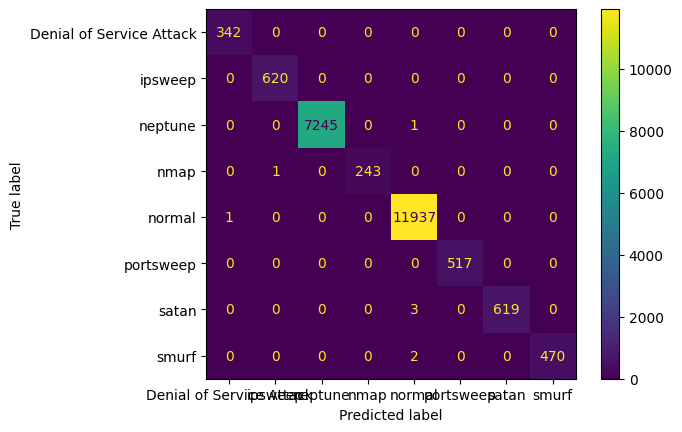

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=pipeline.classes_).plot()

In [ ]:
accuracy_score(y_test, y_pred)

0.9996363801645379

In [ ]:
y_test.value_counts()

normal                      12108
neptune                      7429
ipsweep                       651
satan                         650
portsweep                     537
smurf                         479
Denial of Service Attack      372
nmap                          264
Name: type_of_attack, dtype: int64

In [ ]:
np.unique(y_pred, return_counts=True)

(array(['Denial of Service Attack', 'ipsweep', 'neptune', 'nmap', 'normal',
        'portsweep', 'satan', 'smurf'], dtype=object),
 array([  372,   693,  7428,   221, 12119,   533,   646,   478],
       dtype=int64))

In [ ]:
pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', MinMaxScaler())]),
                                  Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
        'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
        'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
        'num_shells', 'num_access_files'...
        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate'],
       dtype='object')),
                                 ('cat',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImpute

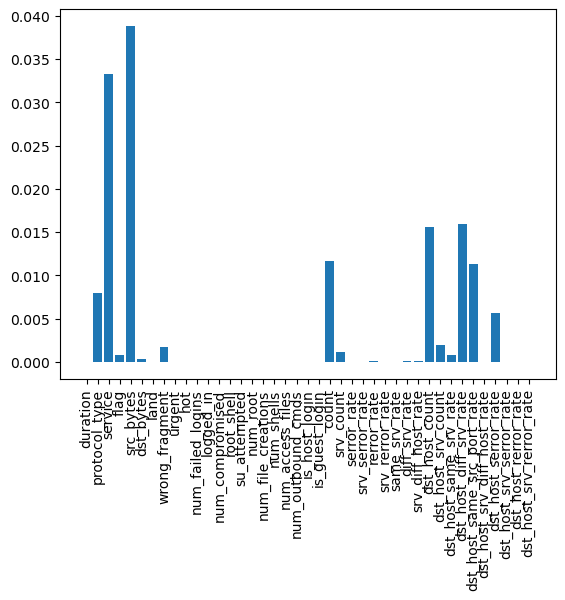

In [ ]:
feature_importances = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42
)
features = X_train.columns
importances = feature_importances.importances_mean

plt.bar(features, importances)
plt.xticks(rotation=90)
plt.show()

In [ ]:
pipeline.feature_names_in_

array(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'], dtype=object)

In [ ]:
clf.feature_importances_.shape

(120,)

<Figure size 1000x1000 with 0 Axes>

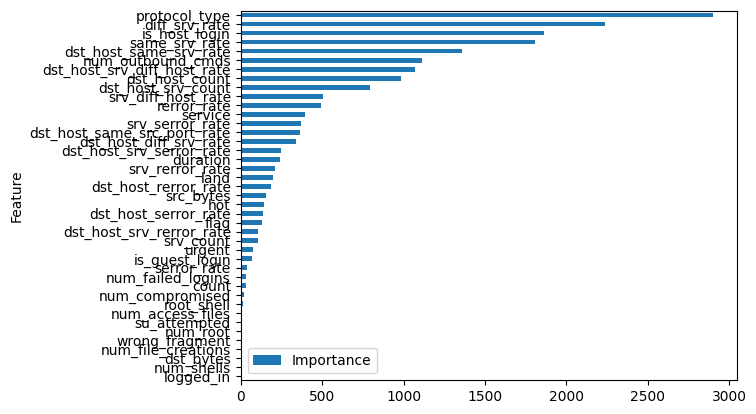

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# retrieving the RF Classifier from the model pipeline
clf = pipeline[-1]
# making a pandas dataframe
data = list(zip(pipeline.feature_names_in_, clf.feature_importances_))
df_importances = pd.DataFrame(data, columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=True)
df_importances.plot.barh(x='Feature', y='Importance')
plt.figure(figsize=(10,10))